In [125]:
import ccxt
exchange = ccxt.binance()
data = exchange.fetch_ohlcv('BTC/USDT', timeframe='1d', limit=500)

In [126]:
import pandas as pd
from datetime import datetime
df=pd.DataFrame(data)


In [128]:
df.columns=['Date','open','High','Low','Close','volume']

In [130]:
df['Date'] = pd.to_datetime(df['Date'], unit='ms')

In [131]:
df.head(1)

,Date,open,High,Low,Close,volume
0,2023-07-04,31156.2,31350.69,30620.0,30766.51,33206.11943


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    500 non-null    datetime64[ns]
 1   open    500 non-null    float64       
 2   High    500 non-null    float64       
 3   Low     500 non-null    float64       
 4   Close   500 non-null    float64       
 5   volume  500 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 23.6 KB


In [133]:
# 1.Preprocessing the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(df[['Close']])

In [134]:
# 2.Spliting the data into training (70%) , validation(15%), and test sets (15%)

train_data=scaled_data[:350]
val_data=scaled_data[350:425]
test_data=scaled_data[425:]

In [175]:
# 3.create LSTM sequence
import numpy as np
def create_sequence(data,lookback):
  x,y=[],[]
  for i in range(len(data)-lookback-1):
    a=data[i:i+lookback]
    x.append(a)
    b=data[i+lookback]
    y.append(b)
  return np.array(x),np.array(y)
lookback=60
x_train,y_train=create_sequence(train_data,lookback)
x_val,y_val=create_sequence(val_data,lookback)
x_test,y_test=create_sequence(test_data,lookback)

In [181]:

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

In [ ]:
#4. Building and Compiling an LSTM Model for Time Series Prediction
model=Sequential()
# First LSTM layer with 50 units and a dropout of 0.2
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1 )))
model.add(Dropout(0.2))

# Second LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer with one unit (predicting the next price)
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])

In [187]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
x_train.shape

(289, 60, 1)

In [ ]:
# 5. Fitting the LSTM model for the training set and validating the model for unseen data the validation set 
history = model.fit(x_train, y_train, epochs=11, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/11


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0891 - mse: 0.0891 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 2/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 4/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 5/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 8/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 9/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0036 - mse: 0.

In [ ]:
# 6. Predicting the values of the y for the test set 
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


In [ ]:
# 7. Evaluating the model using RMSE and MAPE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
print(f"RMSE: {rmse}")

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_rescaled, predictions)
print(f"MAPE: {mape}%")

RMSE: 6600.43577126224
MAPE: 6.561751766066242%


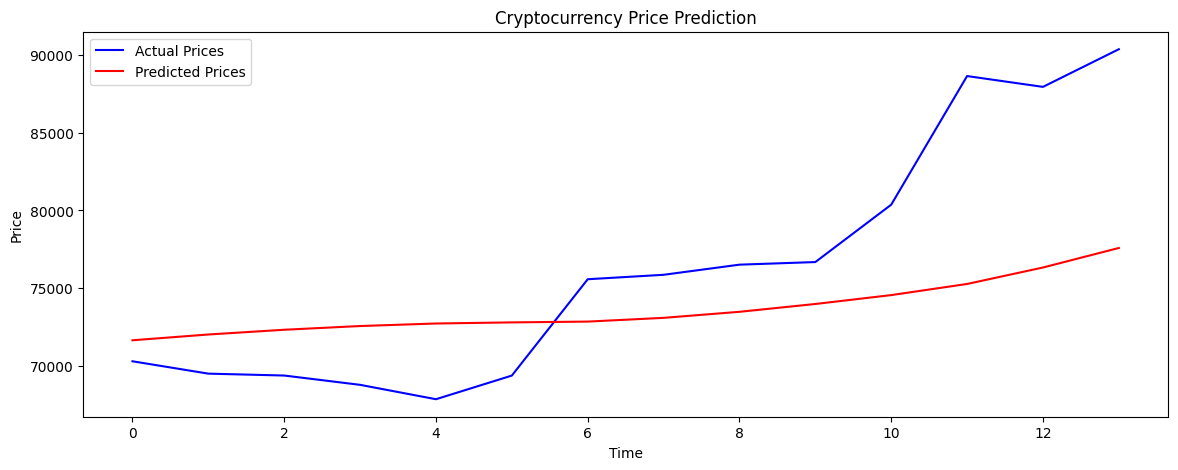

In [ ]:
# 8. Plotting Graph between Actutal and Predicted Prices
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test_rescaled, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title('Cryptocurrency Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# 9. Implementing Early Stopping to avoid over fitting in Model Training.

from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)
ES_history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stop])

Epoch 1/100


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0031 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE: 7971.568889525529
MAPE: 7.083371238557208%


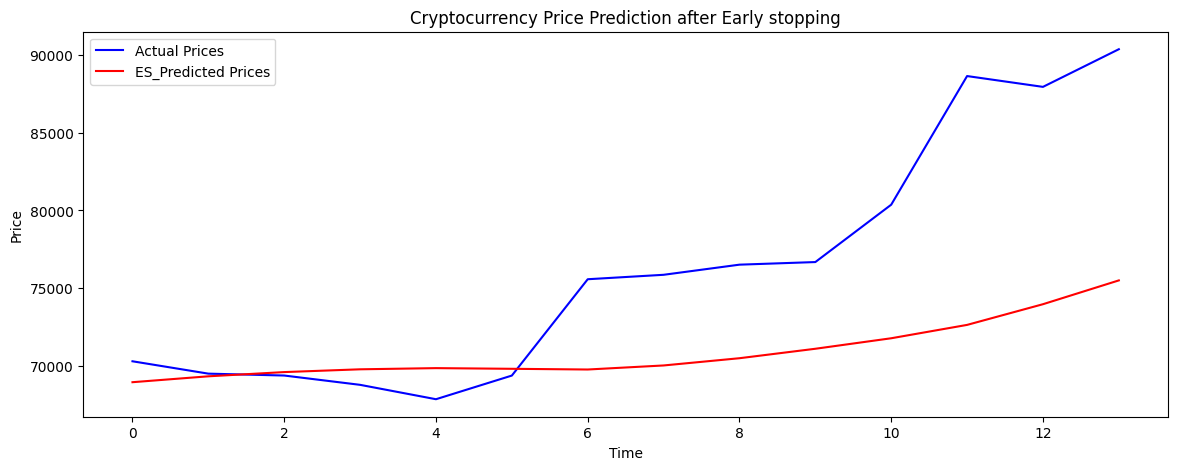

In [ ]:
# 10. Plotting the Graphs after Early Stopping.
ES_predictions=model.predict(x_test)
ES_predictions=scaler.inverse_transform(ES_predictions)
y_test_rescaled = scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, ES_predictions))
print(f"RMSE: {rmse}")


mape = mean_absolute_percentage_error(y_test_rescaled, ES_predictions)
print(f"MAPE: {mape}%")
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test_rescaled, color='blue', label='Actual Prices')
plt.plot(ES_predictions, color='red', label='ES_Predicted Prices')
plt.title('Cryptocurrency Price Prediction after Early stopping')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()